# Import Modules

In [70]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict

warnings.filterwarnings('ignore')

In [71]:
os.getcwd()
file_path = '/Users/talhajamal/Desktop/Code/ChallengeData24/qrt/'
os.chdir(file_path)

# Training Data

In [72]:
# Team Statistics
train_home_team_statistics_df = pd.read_csv('data/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('data/Train_Data/train_away_team_statistics_df.csv', index_col=0)

# Player Statistics
train_home_player_statistics_df = pd.read_csv('data/Train_Data/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('data/Train_Data/train_away_player_statistics_df.csv', index_col=0)

# Train Scores
train_scores = pd.read_csv('data/Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


# Test Data

In [73]:
# Team Statistics
test_home_team_statistics_df = pd.read_csv('data/Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('data/Test_Data/test_away_team_statistics_df.csv', index_col=0)

# Player Statistics
test_home_player_statistics_df = pd.read_csv('data/Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('data/Test_Data/test_away_player_statistics_df.csv', index_col=0)


test_home = test_home_team_statistics_df
test_away = test_away_team_statistics_df

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [74]:
test_home

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,3.0,6.0,5.0,1.0,3.0,9.0,8.0,10.0,6.0,7.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.0,6.0,2.0,3.0
12304,3.0,2.0,4.0,2.0,6.0,1.0,1.0,2.0,4.0,10.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.0,1.0,0.0,2.0
12305,7.0,10.0,8.0,8.0,1.0,4.0,5.0,0.0,10.0,4.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.0,9.0,NaN,0.0
12306,5.0,7.0,5.0,9.0,5.0,7.0,6.0,3.0,5.0,8.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.0,2.0,2.0,3.0
12307,5.0,4.0,6.0,3.0,5.0,0.0,0.0,2.0,2.0,9.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,5.0,5.0,5.0,5.0,7.0,6.0,6.0,4.0,6.0,8.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.0,5.0,2.0,0.0
37667,5.0,5.0,2.0,8.0,3.0,7.0,7.0,2.0,2.0,2.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.0,8.0,10.0,10.0
37668,10.0,10.0,10.0,8.0,8.0,5.0,5.0,2.0,6.0,0.0,...,7.0,0.0,8.0,4.0,0.0,7.0,NaN,2.0,NaN,3.0


# Running a LightGBM Model

In [75]:
def lgbm_cv_grid_search(X, Y):
    """
    Function to run a LGBM model with Cross Validation and Grid Search to Optimize the Parameters
    """

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8, random_state=42)
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

    # Define parameters for LightGBM
    param_grid = {
        'boosting_type': 'gbdt',
        'max_depth': 8, 
        'learning_rate': 0.025,
        'objective': 'multiclass',
        'num_class': 2,
        'metric': 'multi_logloss',
        'num_leaves': 31  # Set a reasonable value for num_leaves
    }

    # Create LGBM datasets
    train_data = lgb.Dataset(X_train.replace({0: np.nan}), label=y_train)
    valid_data = lgb.Dataset(X_valid.replace({0: np.nan}), label=y_valid)

    # Train the model
    bst = lgb.train(param_grid, 
                    train_data, 
                    num_boost_round=10000, 
                    valid_sets=[train_data, valid_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=5)])

    # Test LGBM dataset
    predictions = bst.predict(X_test, iteration_range=(0, bst.best_iteration))
    predictions = pd.DataFrame(predictions)

    lgb.plot_importance(bst, max_num_features=25)
    fig = plt.gcf()
    fig.set_size_inches(15, 20)

    predictions[2] = 0
    predictions.columns = [0,2,1]
    predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values

    target = train_scores.loc[X_test.index].copy()

    print(np.round(accuracy_score(predictions,target),4))

    submission_predictions = bst.predict(test_data, iteration_range=(0, bst.best_iteration))
    submission_predictions = pd.DataFrame(submission_predictions)

    submission_predictions[2] = 0
    submission_predictions.columns = [0,2,1]
    submission_predictions = (submission_predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

    submission_predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
    submission_predictions.index = test_data.index
    submission_predictions = submission_predictions.reset_index()
    submission_predictions.to_csv('data/submission/lgbm_submission.csv', index=False)

    print(submission_predictions.sum(axis=0))

    return bst

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 7873, number of used features: 280
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.368558
[LightGBM] [Info] Start training from score -1.176783
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.47198	valid_1's mult

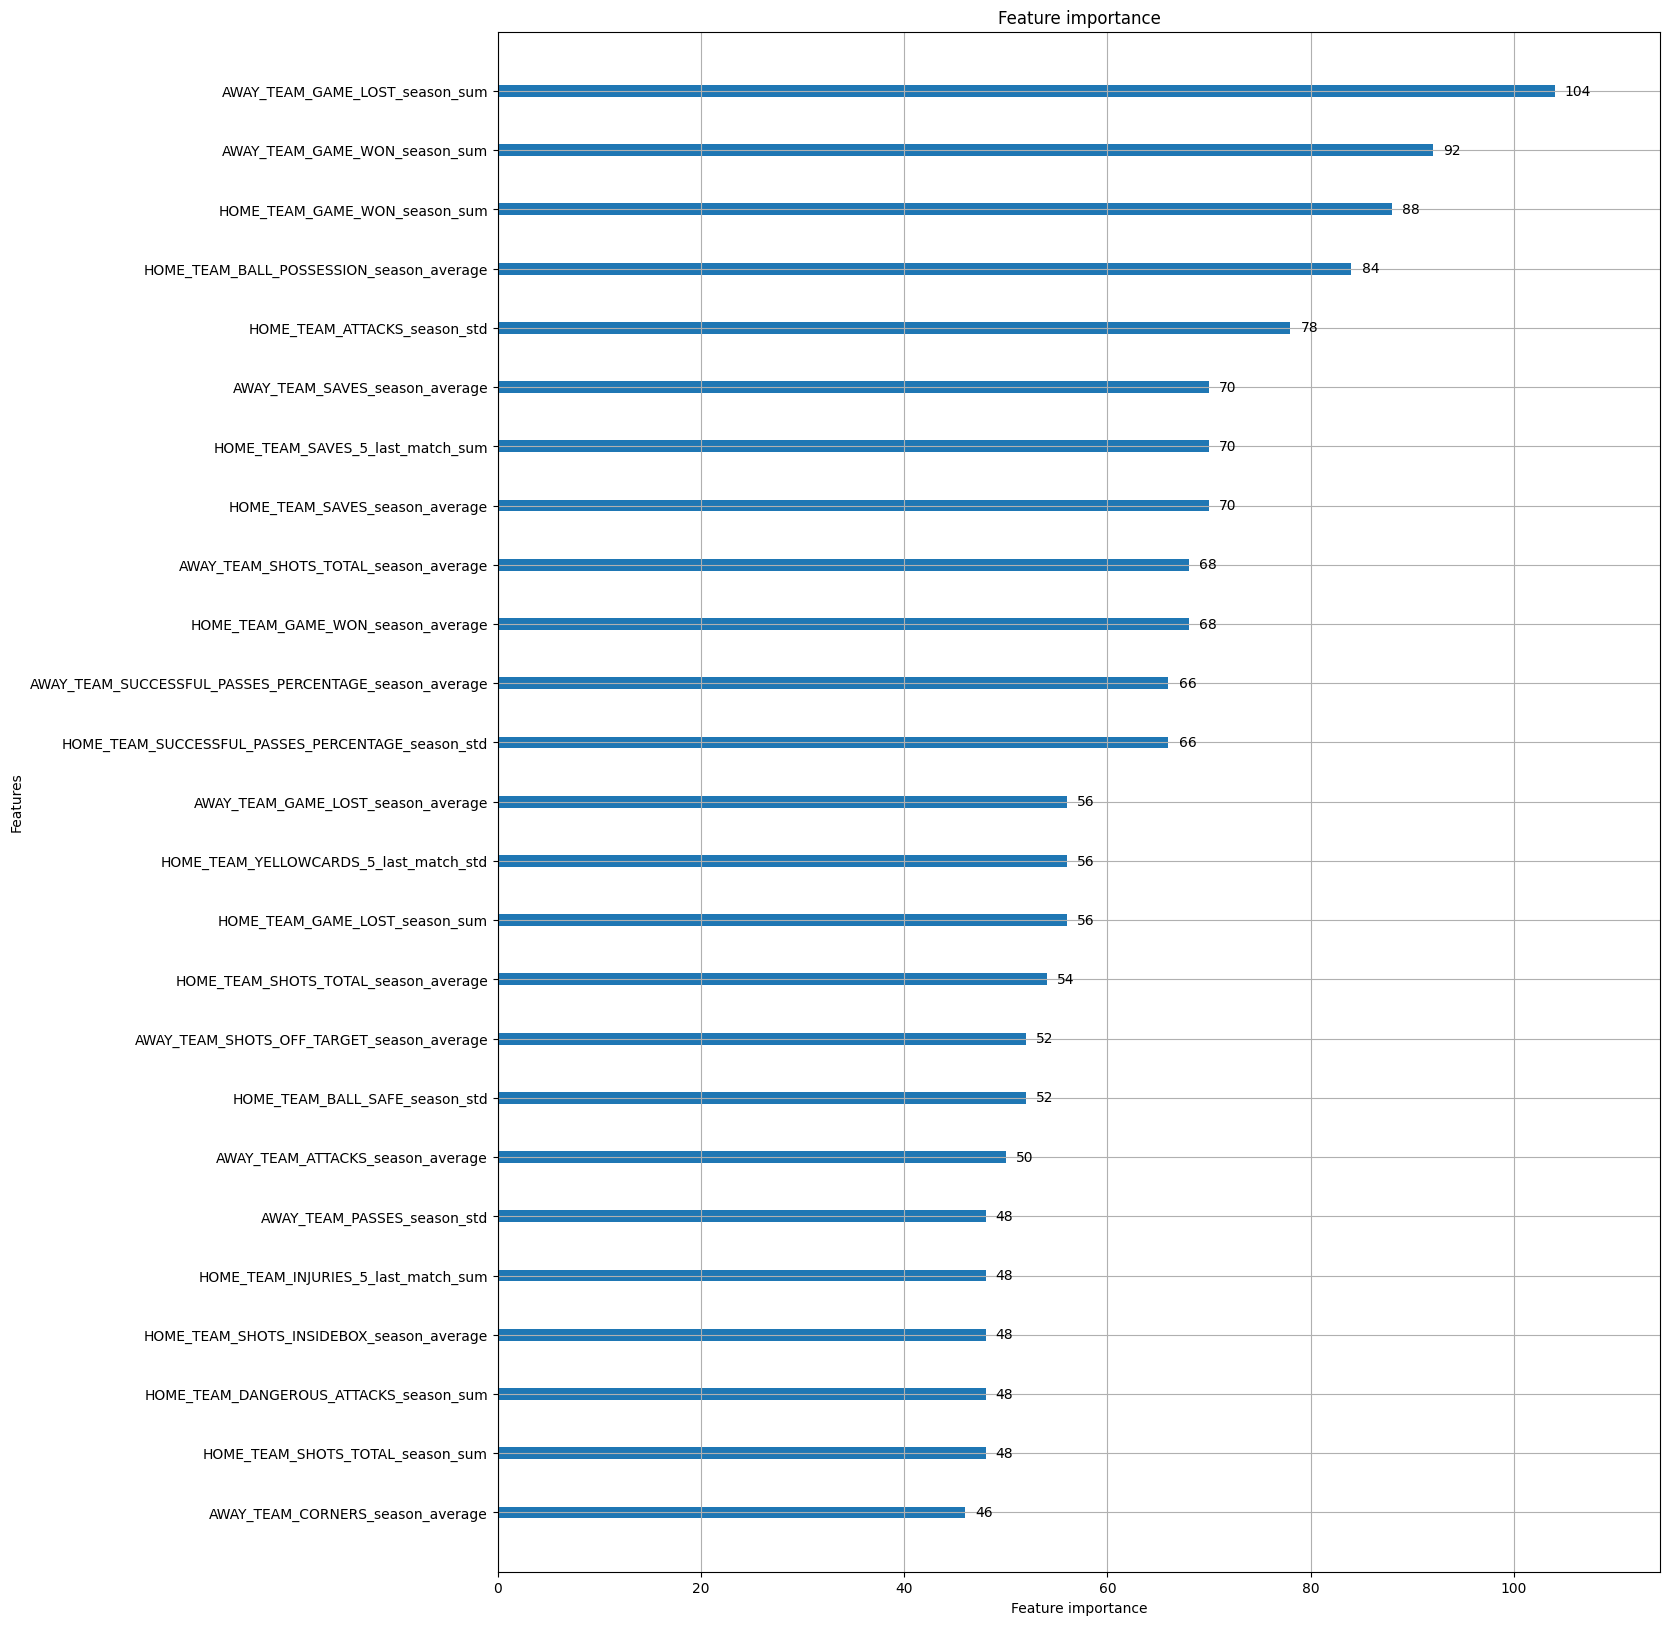

In [76]:
lgbm_cv_grid_search(train_data, train_scores['HOME_WINS'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 7873, number of used features: 280
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.563816
[LightGBM] [Info] Start training from score -0.841725
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.546898	valid_1's mult

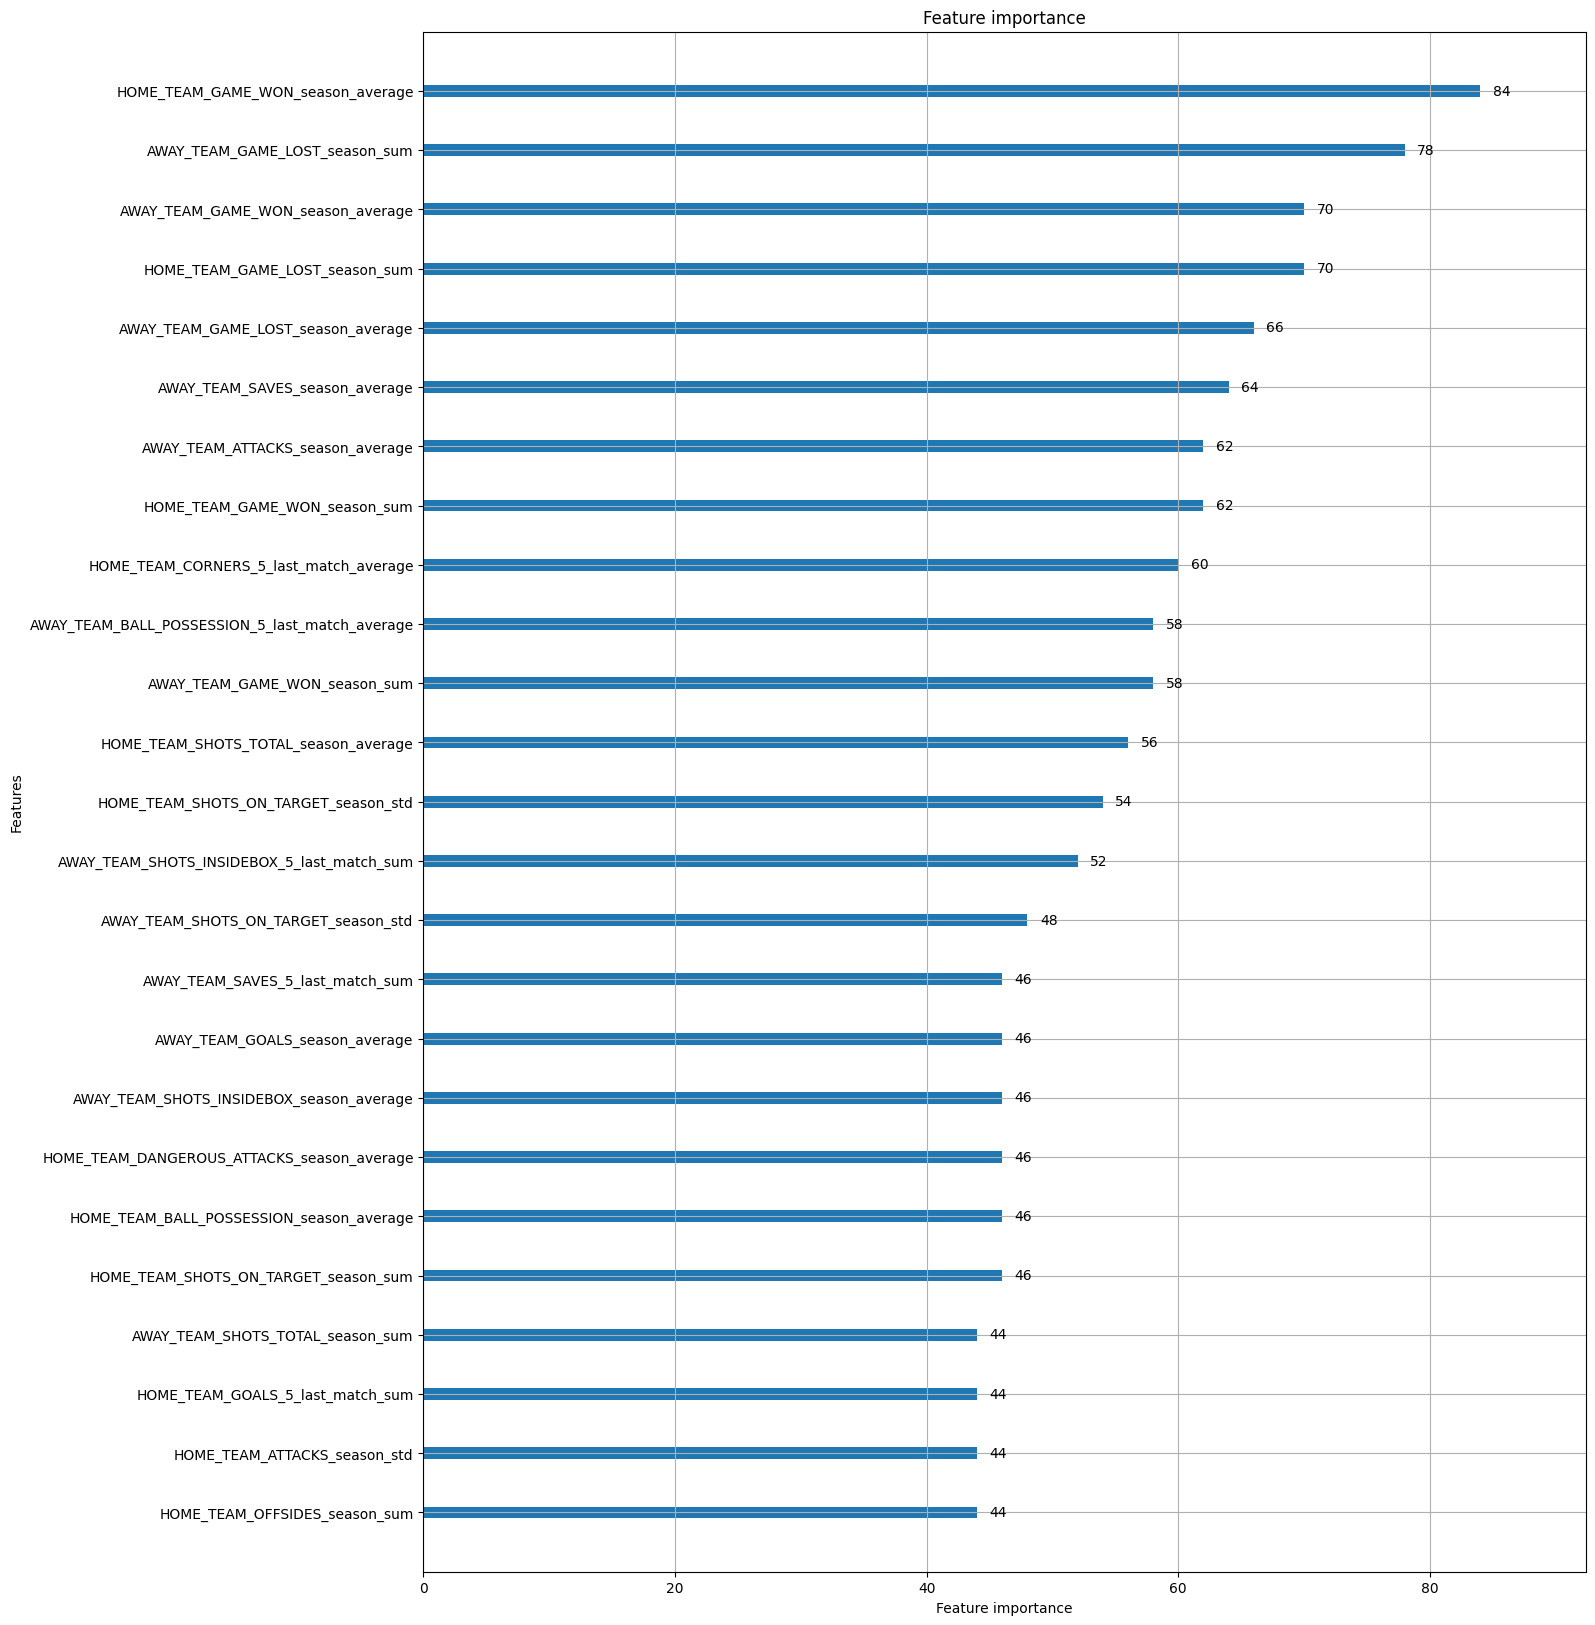

In [77]:
lgbm_cv_grid_search(train_data, train_scores['HOME_WINS'])